## COMP41680 - ASSIGNMENT 1 - DATA COLLECTION AND PREPERATION 
By Hamza Afridi, 19203351

### Objective

To collect data from an API/non static source, store and preprocess it and make preliminary analysis.

### Goal

Conduct social media analysis for Delhi Riots to conduct sentiment analysis and user profiling.

### Background

Following complete [lockdown of Indian-Administered-Kashmir](https://www.aljazeera.com/indepth/inpictures/pictures-100-days-crippling-lockdown-kashmir-191110141155667.html) on August 5, 2019 through abrogation of Article 370 of Indian constitution which gave autonomy to the reagion, government of India, on December 11, 2019, passed a controversial bill called ["Citizenship Amendment Bill"](https://www.bbc.com/news/world-asia-india-50670393), which aimed to provide citizenship to non-muslim minorities through naturalization. These two events were were opposed [nationally](https://edition.cnn.com/2019/12/31/opinions/india-citizenship-law-crosses-line-singh/index.html) and [internationally](https://www.indiatoday.in/india/story/caa-protest-world-students-international-foreign-modi-india-1637241-2020-01-16). Fueling religious radicalization, these events led [riots](https://en.wikipedia.org/wiki/2020_Delhi_riots) in major cities in the country, more specifically Delhi, capital of India. These riots are reffered to as **Delhi Riots**.

[EU DisinfoLab](https://www.disinfo.eu/), a Brussels based NGO, focused on tackling disinformation campaigns targeting EU, on November 26, 2019 realeased a report titled, ["Uncovered: 265 coordinated fake local media outlets serving Indian interests"](https://www.disinfo.eu/publications/uncovered-265-coordinated-fake-local-media-outlets-serving-indian-interests). This report further raised questions on authenticity of online content and this extends to content on social media. Governments and lobbyists have been using [social media](https://www.nytimes.com/2020/03/29/technology/facebook-google-twitter-november-election.html) to stir public preception.

### Approach

To achieve above set goal, tweets will be extracted for this particular the [hashtag](https://help.twitter.com/en/using-twitter/how-to-use-hashtags) **#delhiriots**. Unique users will be identified and keyword will be identified. This approch is illustrated in the figure below:

![](analysis_hashtag_delhiriots.jpeg)

### Data Identification

#### Platform selection

Criterion for platform selection are as following:  
- textual rich data
- api/tool for data collection availability  
- amount of disucussion  


In order to conduct this analysis, following social media analysis are considered:  
- facebook
- twitter
- reddit  

For this assignment **twitter** is chosen and data is acquired using [twint](https://github.com/twintproject/twint) an opensource library to fetch twitter public data without any limit. Figure below shows rationale behind the decision for platform and tool selection.

![](platform_selection_mindmap.jpeg)

#### Tool selection

Inorder to collect data for this assignment [twint](https://github.com/twintproject/twint) is used. Twint is an advanced twitter scrapping tool which has no limits and no authentication required. The project is 2 years old, however, there is [active participation](https://github.com/twintproject/twint/graphs/code-frequency) by contributors.  

In [1]:
#suppress warnings generated by ipython for cleaner working
import warnings
warnings.simplefilter('ignore')

In [33]:
import twint #twitter scrapping tool
import nest_asyncio #twint has dependency on this
import os #to measure file size
import time #to process time data
import pandas as pd
import seaborn as sns #plotting tool
import matplotlib.pyplot as plt #plotting tool

### Data collection

There are two steps to data collection:  
1. collect and store tweets
2. extract contributing twitter handles and collect profile data for them

#### Collect and store tweets 
Due to some network issue system would break after acquiring 14000 (approx.) tweets. Thus implemented a safe aquring 10k tweets at a time with delay 30sec after each request is implemented so that it doesn't appear as a ddos attack. 

In [109]:
nest_asyncio.apply() #so that multiple requests can be made at the same time
tweet_client = twint.Config() # configure a client

#search configuration
tweet_client.Search = "delhiriots" #serach querry
tweet_client.Limit = 10000 #max number of results
tweet_client.Store_csv = True #store data to a csv file by appending it
tweet_client.Output = "tweets.csv" #file name
tweet_client.Hide_output = True #do not print output in the notebook
tweet_client.Resume = 'last_qerry.txt'#last checkpoint to continue search incase of error

In [130]:
old_size = os.path.getsize('./tweets.csv') #track file size
twint.run.Search(tweet_client) #run search
new_size = os.path.getsize('./tweets.csv') #track file size

In [134]:
while(old_size<new_size):
    twint.run.Search(tweet_client) #run search
    old_size = new_size
    new_size = os.path.getsize('./tweets.csv') #track file size
    time.sleep(30)

#### Collect and store participating user data 

This can be accomplished using preliminary data extraction and processing from raw data aquired in previous section. This will be accomplished by: 
- selecting only twitter handle from tweets.csv 
- removing duplicates if any
- acquire user data for each user

In [155]:
# reading twitter handles from tweets.csv
participant_handles_df = pd.read_csv('tweets.csv', usecols=['username'])

# remove duplicates
participant_handles_df.drop_duplicates(inplace=True)
participant_handles_df.to_csv("unique_users.csv") # store users for future use

In [161]:
print("number of unique users: ",participant_handles_df.shape[0])

number of unique users:  58512


In order to aquire these many users data simultanously we will employ technique of multiprocessing

In [170]:
import threading #multiprocessing
import asyncio

def search_query(username):
    asyncio.set_event_loop(asyncio.new_event_loop())
    
    #client configuration
    user_client = twint.Config()
    user_client.Store_csv = True
    user_client.Hide_output = True
    user_client.Output = "users_parallel.csv"
    for user in username:
        user_client.Username = user
        twint.run.Lookup(user_client)

max_queries=100 #number of simultanous querries
user_thread=[]

#generating and starting threads
for i in range(max_queries):
    user_thread.append(threading.Thread(target=search_query, args=(participant_handles_df.username[580*i:580*i+579],)))
    user_thread[i].start()

### Data preperation and analysis

#### Data loading

In this step both tweets and users data are stored in seperate data frames.

In [196]:
tweets_df = pd.read_csv("tweets.csv") # read tweets data and store in dataframe
users_df = pd.read_csv("users.csv") # read users data and store in dataframe

In [197]:
tweets_df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1244589465558900737,1244589465558900737,1585568226000,2020-03-30,12:37:06,GMT Daylight Time,53000919,frontline_india,Frontline,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '53000919', 'username': 'frontlin...",NaN,NaN,NaN,NaN
1,1244589296482275328,1244589296482275328,1585568186000,2020-03-30,12:36:26,GMT Daylight Time,2840969317,sk_choudhary22,shubham kr.choudhary,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '2840969317', 'username': 'SK_Cho...",NaN,NaN,NaN,NaN
2,1244586785981620225,1244586785981620225,1585567587000,2020-03-30,12:26:27,GMT Daylight Time,1131530614551633923,jha_bhawana,Bhawana Jha,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '1131530614551633923', 'username'...",NaN,NaN,NaN,NaN
3,1244586558348390402,1244508501214289921,1585567533000,2020-03-30,12:25:33,GMT Daylight Time,164961165,hum_deke_rhenge,Azaadi,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '164961165', 'username': 'hum_dek...",NaN,NaN,NaN,NaN
4,1244585341761146880,1244580631100588034,1585567243000,2020-03-30,12:20:43,GMT Daylight Time,803088607,patilrakesh85,Rakesh Patil,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '803088607', 'username': 'PatilRa...",NaN,NaN,NaN,NaN


As can be seen from the priliminary evaluation of above data there are many columns that are irrelavent to our analysis and can be safely dropped.

In [198]:
users_df.head()

,id,name,username,bio,location,url,join_date,join_time,tweets,following,followers,likes,media,private,verified,profile_image_url,background_image
0,53000919,Frontline,frontline_india,A fortnightly magazine from The Hindu Group of...,Chennai,http://www.frontline.in,2 Jul 2009,12:25 AM,7044,10,35349,312,1808,0,1,https://pbs.twimg.com/profile_images/880687855...,https://pbs.twimg.com/profile_banners/53000919...
1,2840969317,shubham kr.choudhary,SK_Choudhary22,सब सुख लहै तुम्हारी सरना । तुम रक्षक काहू को ड...,NaN,NaN,5 Oct 2014,12:10 AM,43,49,13,159,15,0,0,https://pbs.twimg.com/profile_images/118073615...,https://pbs.twimg.com/profile_banners/28409693...
2,1131530614551633923,Bhawana Jha,jha_bhawana,Always high on life! Big foodie!! Likes to be ...,NaN,NaN,23 May 2019,5:01 AM,46,217,28,406,4,0,0,https://pbs.twimg.com/profile_images/113154037...,https://pbs.twimg.com/profile_banners/11315306...
3,164961165,Azaadi,hum_deke_rhenge,NaN,"New Delhi, India",NaN,9 Jul 2010,10:49 PM,3406,134,42,175,850,0,0,https://pbs.twimg.com/profile_images/121883697...,NaN
4,803088607,Rakesh Patil,PatilRakesh85,Inspiration - Shivaji Maharaj. If he can fight...,NaN,NaN,4 Sep 2012,12:49 PM,10196,588,480,25388,92,0,0,https://pbs.twimg.com/profile_images/998249215...,https://pbs.twimg.com/profile_banners/80308860...


Similar to previous case we can drop multiple features from here as they are not relavent to our goals or are empty anyways.

#### Feature analysis

In this step we will coduct an inspection of columns/features of raw data for both data sets. We will make conclusions to which columns to drop in the preprocessing step.

Let's look at columns/features of tweets data.

In [199]:
tweets_df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'mentions', 'urls',
       'photos', 'replies_count', 'retweets_count', 'likes_count', 'hashtags',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest'],
      dtype='object')

From the feature list above following are the relavent features:
- created_at
- date
- time
- timezone
- username
- tweet
- mentions
- replies_count
- retweet_count
- likes_count
- hashtag

In [200]:
users_df.columns

Index(['id', 'name', 'username', 'bio', 'location', 'url', 'join_date',
       'join_time', 'tweets', 'following', 'followers', 'likes', 'media',
       'private', 'verified', 'profile_image_url', 'background_image'],
      dtype='object')

From the features above following are relavent features:
- name
- username
- bio
- location
- join_date
- join_time
- tweets
- following
- followers
- likes
- private
- verified

#### Preprecessing

In this step I will have the data go through the following steps:
- drop irrelevant columns (features) from both datasets
- extract tweets that are before the event and keep a seperate copy
- convert date column to datetime format
- drop tweets that are before the event (February 2020)
- join the the two data sets appropriately

##### droping irrelavent features

In [201]:
#drop columns that are not required in tweets dataframe
tweets_df.drop(columns=['id', 'conversation_id', 'user_id', 'name', 'place', 'urls', 'photos',
       'cashtags', 'link', 'retweet', 'quote_url', 'video', 'near', 'geo',
       'source', 'user_rt_id', 'user_rt', 'retweet_id', 'reply_to',
       'retweet_date', 'translate', 'trans_src', 'trans_dest'], axis=1, inplace=True)

In [202]:
#verify if drop of columns successful in tweets dataframe
tweets_df.columns

Index(['created_at', 'date', 'time', 'timezone', 'username', 'tweet',
       'mentions', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags'],
      dtype='object')

In [203]:
#drop columns that are not required in users dataframe
users_df.drop(columns=['id', 'url', 'media', 'profile_image_url', 'background_image'], axis=1, inplace=True)

In [204]:
#verify if drop of columns successfil in users dataframe
users_df.columns

Index(['name', 'username', 'bio', 'location', 'join_date', 'join_time',
       'tweets', 'following', 'followers', 'likes', 'private', 'verified'],
      dtype='object')

##### covert date column to datetime datetype

This conversion is easily accomplished using to_datetime function in pandas.

In [205]:
tweets_df['date'] = pd.to_datetime(tweets_df.date)
users_df['join_date'] = pd.to_datetime(users_df.join_date)

In [206]:
#verification of successful conversion
tweets_df['date'].head()

0   2020-03-30
1   2020-03-30
2   2020-03-30
3   2020-03-30
4   2020-03-30
Name: date, dtype: datetime64[ns]

Before going anyfurther lets looks at when the oldest tweet was when we got this data

In [207]:
print("oldest tweet date:",min(tweets_df.date))

oldest tweet date: 2008-08-19 00:00:00


looks like we have older data, we will have to drop anything older than our time of interest

##### extrating tweets older than 1st February 2020

In [208]:
tweets_bft = tweets_df[(tweets_df.date<"2020-02-22")] #filter tweets older than 22nd February 2020

In [209]:
#verify successful filtering
max(tweets_bft.date)

Timestamp('2020-02-21 00:00:00')

##### drop tweets before the event

In [210]:
tweets_df = tweets_df[(tweets_df.date>"2020-02-21")] #filter tweets latest than 22nd February 2020

In [211]:
#verify successful filtering
min(tweets_df.date)

Timestamp('2020-02-22 00:00:00')

##### join users and tweets data frames

However, joining the two dataframes might not be an efficient solution. This step is just being done to demonstrate understading of integrating data together.

In [212]:
tweet_user_df = tweets_df.set_index('username').join(users_df.set_index('username')) #join with username as key

In [213]:
tweet_user_df.columns

Index(['created_at', 'date', 'time', 'timezone', 'tweet', 'mentions',
       'replies_count', 'retweets_count', 'likes_count', 'hashtags', 'name',
       'bio', 'location', 'join_date', 'join_time', 'tweets', 'following',
       'followers', 'likes', 'private', 'verified'],
      dtype='object')

In [214]:
# the below filter has been set as participating users were too large (58k+) even with multiprocessing it is taking more time. So only 1400 were extracted for the purpose of this assignment 
tweet_user_df[~(tweet_user_df.join_date.isna())].head(2)

,created_at,date,time,timezone,tweet,mentions,replies_count,retweets_count,likes_count,hashtags,...,bio,location,join_date,join_time,tweets,following,followers,likes,private,verified
username,,,,,,,,,,,,,,,,,,,,,
0088com,1585294189000,2020-03-27,07:29:49,GMT Daylight Time,This man deserve death with stones in open are...,"['jkpdp', 'ranaayyub', 'iamrana', 'deepikasraj...",0,0,0,[],...,help others,Srinagar Jammu and Kashmir,2011-10-16,11:15 AM,198.0,467.0,20.0,308.0,0.0,0.0
12sanskar,1584527619000,2020-03-18,10:33:39,GMT Daylight Time,Small contribution from me\nFor our hindus fam...,"['kapilmishra_ind', 'tajinderbagga', 'real_anuj']",1,4,12,['#1crore4delhihindu'],...,NaN,"Ajmer, India",2019-05-20,8:35 PM,3519.0,4518.0,5098.0,3660.0,0.0,0.0


#### Analysis


##### from tweets data

##### tweet frequency analysis

As we have have already filtered tweets data, let's first analyze the frequecy of tweets overtime.

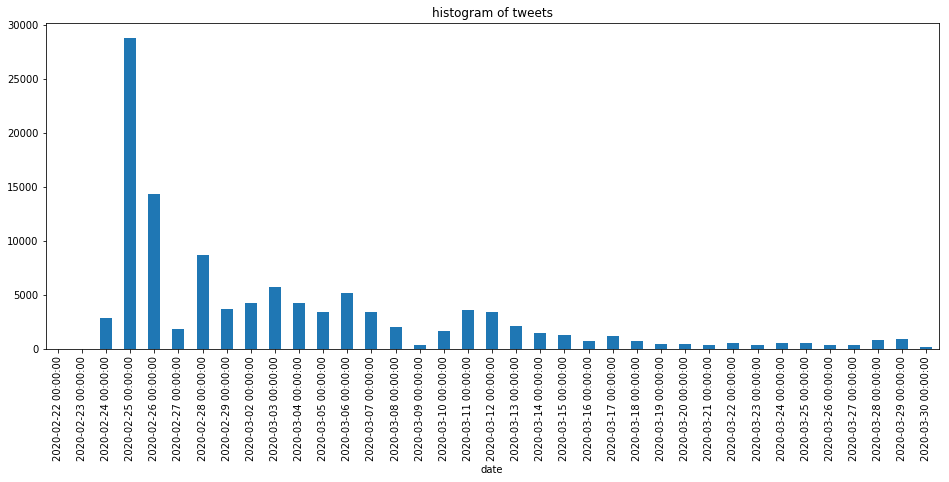

In [215]:
date_df=tweets_df.date.groupby(tweets_df["date"]).count() #group by using date to generate histogram
date_df.plot(kind="bar", title="histogram of tweets", figsize=(16,6))

Above histogram shows that the during the riots there were maximum number of tweets, thus highlighting the importance of this issue. Maximum number of tweets are dated for 25 February, 2020.

##### engagement analysis

Another important analysis would be to visualize engagements on tweets. For this we will filter out any tweet that has zero interaction and visualize the spread of the data using boxplot.

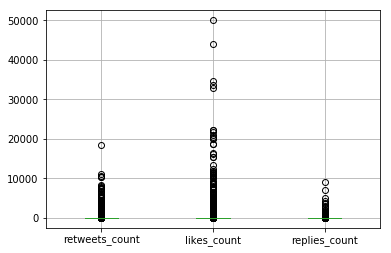

In [216]:
tweets_df[['retweets_count','likes_count','replies_count']].boxplot()

As clear from the above diagram most engagement is closer to zero. If we filter that out we can have better understanding of spread. Also there are clearly few outliers, with significant likes and/or retweets.

We will now generate box plot again by ignoring tweets greater than 0 engagments.

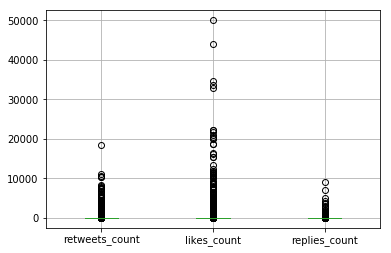

In [217]:
tweets_df[((tweets_df.retweets_count+tweets_df.likes_count+tweets_df.replies_count)>0)][['retweets_count','likes_count','replies_count']].boxplot()

No signigicant different is observed. Let's visualize distribution of these engagements. Note: engagement is sum of retweets, likes and replies count.

Text(0.5, 1.0, 'distribution of engagement')

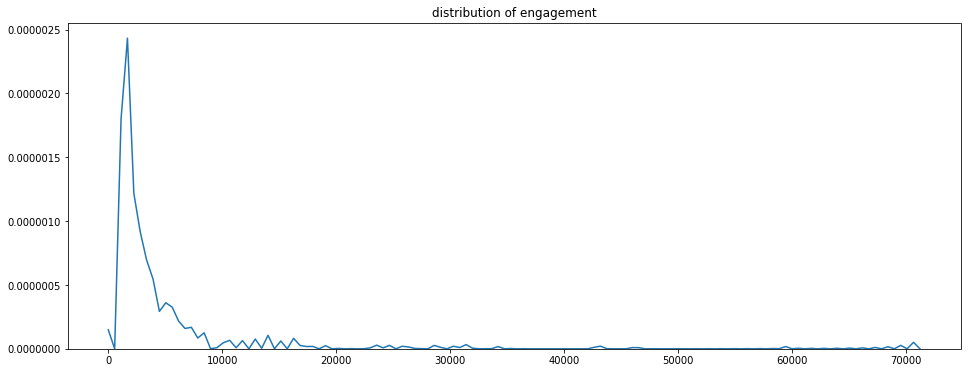

In [218]:
plt.figure(figsize=(16, 6))
sns.distplot(tweets_df.retweets_count+tweets_df.likes_count+tweets_df.replies_count, hist=False, bins=1).set_title("distribution of engagement")

The clear spike not close to zero suggests that this was a highly engaging topic. There was contribution to the discussion by the participants.

##### top tweets

We will now analyze tweet of the with highest engagement feature both individual and commulative.

In [219]:
#tweet with most likes
best_tweet_likes = tweets_df[(tweets_df.likes_count==max(tweets_df.likes_count))]
print("Best tweet based on likes: \"%s\" by %s"%(best_tweet_likes.tweet.values[0], best_tweet_likes.username.values[0]))

Best tweet based on likes: "Stop blaming Modi for Delhi riots and all things evil in India   https://gulfnews.com/opinion/op-eds/stop-blaming-modi-for-delhi-riots-and-all-things-evil-in-india-1.1583761983415 …" by abdulhamidahmad


In [220]:
#tweet with most likes
best_tweet_retweets = tweets_df[(tweets_df.retweets_count==max(tweets_df.retweets_count))]
print("Best tweet based on retweets: \"%s\" by %s"%(best_tweet_retweets.tweet.values[0], best_tweet_retweets.username.values[0]))

Best tweet based on retweets: "Stop blaming Modi for Delhi riots and all things evil in India   https://gulfnews.com/opinion/op-eds/stop-blaming-modi-for-delhi-riots-and-all-things-evil-in-india-1.1583761983415 …" by abdulhamidahmad


In [221]:
#tweet with most replies
best_tweet_replies = tweets_df[(tweets_df.replies_count==max(tweets_df.replies_count))]
print("Best tweet based on replies: \"%s\" by %s"%(best_tweet_replies.tweet.values[0], best_tweet_replies.username.values[0]))

Best tweet based on replies: "Post-mortem report shows IB staffer Ankit Sharma, killed in Delhi riots, was stabbed 12 times and not 400 times

@BhardwajAnanya reports

#ThePrintExclusive http://bit.ly/2QdJWLW " by shekhargupta


In [222]:
#tweet with most engagements
best_tweet_engagements = tweets_df[((tweets_df.retweets_count+tweets_df.likes_count+tweets_df.replies_count)==max(tweets_df.retweets_count+tweets_df.likes_count+tweets_df.replies_count))]
print("Best tweet based on engagement: \"%s\" by %s"%(best_tweet_engagements.tweet.values[0], best_tweet_engagements.username.values[0]))

Best tweet based on engagement: "Stop blaming Modi for Delhi riots and all things evil in India   https://gulfnews.com/opinion/op-eds/stop-blaming-modi-for-delhi-riots-and-all-things-evil-in-india-1.1583761983415 …" by abdulhamidahmad


It can be seen that abdulhamidahmad who is Editor in Cheif of Gulf News got most likes, retweets and likes. On the other shekhargupta who is an Indian journalist got most replies.  

##### from participants data

Now we will analyze participant data.

##### verified users

It is expected to be very small but the engagement of verified vs un-verified is priliminary information we can get from the participating users data.

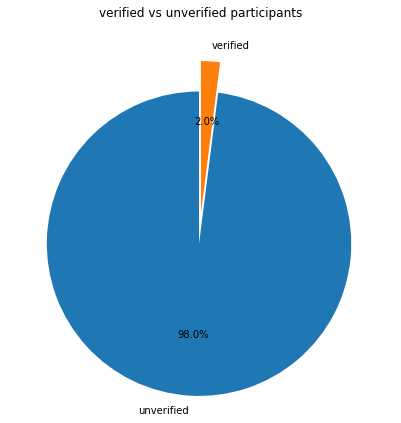

In [223]:
plt.figure(figsize=(7, 7))
plt.title("verified vs unverified participants")
plt.pie(users_df.username.groupby(users_df.verified).count(), labels=["unverified","verified"],autopct='%1.1f%%', explode=[0.2,0],startangle=90)
plt.show()

So from the above pie 2% participants are verified users and 98% are unverified users. Not alot of information is available on what percentage of users are verified. The closest numbers I could get were in this [article](https://www.brandwatch.com/blog/twitter-stats-and-statistics/). However, given strict rules of twitter on verification of twitter handles I believe it's a significant number, which suggests the seriousness of the issue.

##### twitter age analysis

In order to track down fake army accounts twitter age is an important paramter.

In [234]:
users_df["twitter_age"]=max(tweets_df['date'])-users_df['join_date'] #max is the latest tweet that is on 30th March 2020

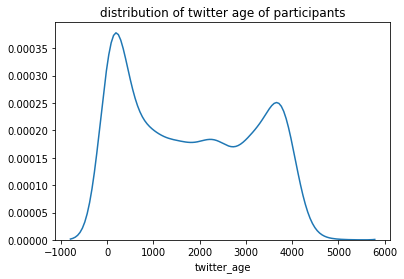

In [235]:
sns.distplot(users_df["twitter_age"].dt.days, hist=False)
plt.title("distribution of twitter age of participants")
plt.show()

Interesting how distribution plots show two peaks. The first peak near zero might be an indicator of creation of twitter army.

##### followers, following, tweets and likes analysis

In order to analyse this I will divide the set into two groups based on age:
1. age < 50 days
2. age > 50 days

In [242]:
#statisitcal description of users with less than 50 days age
users_df[(users_df.twitter_age.dt.days<50)][['tweets',"followers","following","likes"]].describe()

,tweets,followers,following,likes
count,305.000000,305.000000,305.000000,305.000000
mean,891.836066,63.757377,219.455738,1045.652459
std,1596.952332,174.532534,400.802065,1721.453084
min,1.000000,0.000000,0.000000,0.000000
25%,65.000000,2.000000,28.000000,40.000000
50%,302.000000,10.000000,82.000000,261.000000
75%,1062.000000,39.000000,223.000000,1430.000000
max,11615.000000,1783.000000,3536.000000,13397.000000


For participants with are significantly new on twitter, number of average tweets and likes are suspicious. However, this needs to be further investigated to conclude fake users.

In [244]:
#statisitcal description of users with less than 50 days age
users_df[(users_df.twitter_age.dt.days>50)][['tweets',"followers","following","likes"]].describe()

,tweets,followers,following,likes
count,4.577000e+03,4.577000e+03,4577.000000,4577.000000
mean,2.104834e+04,1.374068e+04,670.058117,15464.637754
std,7.403956e+04,2.886870e+05,1828.579081,35888.610798
min,1.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.650000e+02,2.800000e+01,95.000000,549.000000
50%,3.722000e+03,1.090000e+02,253.000000,3434.000000
75%,1.531200e+04,5.000000e+02,626.000000,14012.000000
max,3.481864e+06,1.251379e+07,53481.000000,614615.000000


This is a rought estimation, however, this includes celebrities with verified accounts and huge fan following. So this table will have skewed data.

### Conclusion

Just with priliminary analysis, it has been observed that twint is quite reliable source for data acquisition from twitter. It does however come with it's limitation. Analysis of delhiriots indicate usage of bots to influence public sentiments. However, further investigation has to be performed, to make viable conclusion.

### Future work

With involvement of NLP and other statistical analysis tool this investigation can be taken further and more insights can be taken out from this dataset. If successful these techniques can be employed to track and uncover such global operations.